In [4]:
import edward2

In [8]:

from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import seaborn as sns
import tensorflow as tf
from theano import shared, tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

In [13]:
blue, green, red, purple, gold, teal, x, y, z, q = sns.color_palette()

In [14]:
SEED = 69972 # from random.org, for reproducibility

np.random.seed(SEED)


## Variational Inference

Choose a class of approximating distributions

Find the best approximation to the true posterior

Variational inference minimizes the Kullback-Leibler divergence

$$ \mathbb{KL}(\color{purple}{q(\theta)} \parallel \color{red}{p(\theta\ |\ \mathcal{D})}) = \mathbb{E}_q\left(\log\left(\frac{\color{purple}{q(\theta)}}{\color{red}{p(\theta\ |\ \mathcal{D})}}\right)\right) $$

from approximate distributons, but we can't calculate the true posterior distribution.

Minimizing the Kullback-Leibler divergence

$$ \mathbb{KL}(\color{purple}{q(\theta)} \parallel \color{red}{p(\theta\ |\ \mathcal{D})}) = -(\underbrace{\mathbb{E}_q(\log \color{blue}{p(\mathcal{D}, \theta))} - \mathbb{E}_q(\color{purple}{\log q(\theta)})}_{\color{orange}{\textrm{ELBO}}}) + \log \color{green}{p(\mathcal{D})} $$

is equivalent to maximizing the Evidence Lower BOund (ELBO), which only requires calculating the joint distribution.

![alt text](ELBO_evidence_gap.png "Why maximizing ELBO decreases KL divergence?")




In this example, we minimize the Kullback-Leibler divergence between a full-rank covariance Gaussian distribution and a diagonal covariance Gaussian distribution.

In [15]:
SIGMA_X = 1.
SIGMA_Y = np.sqrt(0.5)
CORR_COEF = 0.75

true_cov = np.array([[SIGMA_X**2, CORR_COEF * SIGMA_X * SIGMA_Y],
                     [CORR_COEF * SIGMA_X * SIGMA_Y, SIGMA_Y**2]])
true_precision = np.linalg.inv(true_cov)

approx_sigma_x, approx_sigma_y = 1. / np.sqrt(np.diag(true_precision))

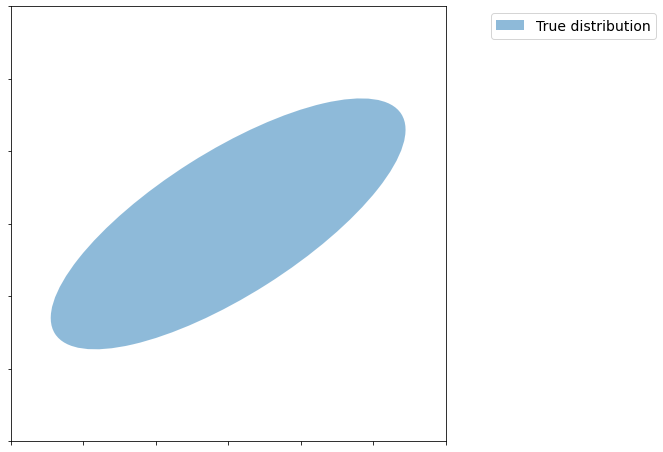

In [16]:
fig, ax  = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal');


var, U = np.linalg.eig(true_cov)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

ax.set_xlim(-3, 3);
ax.set_xticklabels([]);

ax.set_ylim(-3, 3);
ax.set_yticklabels([]);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect],
          ['True distribution'],
          bbox_to_anchor=(1.5, 1.));


Approximate the true distribution using a diagonal covariance Gaussian from the class

$$ \mathcal{Q} = \left\{\left.N\left(\begin{pmatrix} \mu_x \\ \mu_y \end{pmatrix}, \begin{pmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2\end{pmatrix}\ \right|\ \mu_x, \mu_y \in \mathbb{R}^2, \sigma_x, \sigma_y > 0\right)\right\} $$

In [18]:
vi_e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991) * approx_sigma_x, 2 * np.sqrt(5.991) * approx_sigma_y)
vi_e.set_alpha(0.4)
vi_e.set_facecolor(red)
vi_e.set_zorder(11);
ax.add_artist(vi_e);

vi_rect = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.75)

ax.legend([rect, vi_rect],
          ['Posterior distribution',
           'Variational approximation'],
          bbox_to_anchor=(1.55, 1.));

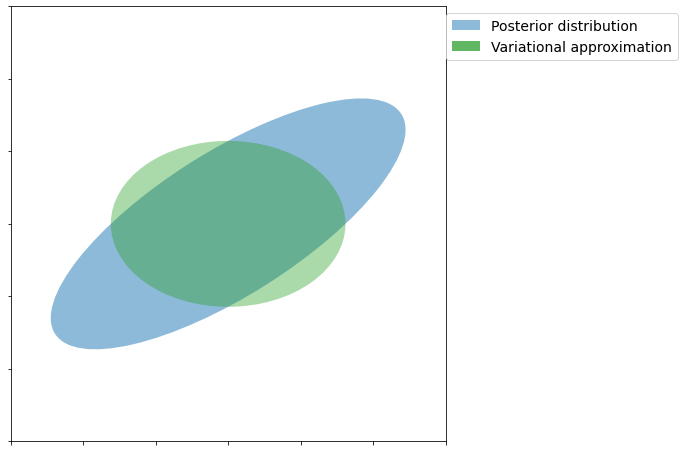

In [19]:
fig

This is just one step. How do we did it over and over?

Black Box Variational Inference

example on beta binomial distribution 

- using MCMC algorithm to calculate the posterior
- using Variational Inference to calculate the posterior 

We observe three successes in ten trials, and want to infer the true success probability.

In [28]:
x_beta_binomial = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [29]:
import pymc3 as pm

with pm.Model() as beta_binomial_model:
    p_beta_binomial = pm.Uniform('p', 0., 1.)

In [33]:
import pymc3 as pm

with pm.Model() as beta_binomial_model:
    p_beta_binomial = pm.Uniform('p', 0., 1.)

In [30]:
with beta_binomial_model:
    x_obs = pm.Bernoulli('y', p_beta_binomial,
                         observed=x_beta_binomial)

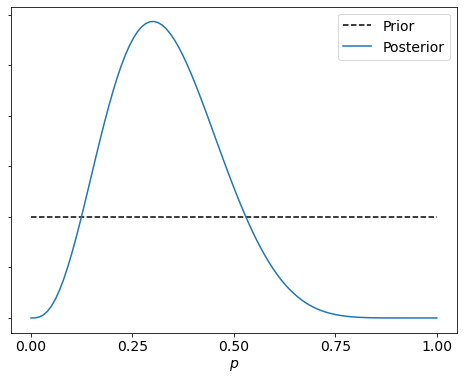

In [61]:
# plot the true beta-binomial posterior distribution
fig1, ax = plt.subplots()

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(), 1 + (1 - x_beta_binomial).sum())

plot_x = np.linspace(0, 1, 100)
ax.plot(plot_x, prior.pdf(plot_x),
        '--', c='k', label='Prior');

ax.plot(plot_x, posterior.pdf(plot_x),
        c=blue, label='Posterior');

ax.set_xticks(np.linspace(0, 1, 5));
ax.set_xlabel(r'$p$');

ax.set_yticklabels([]);

ax.legend(loc=1);

In [62]:
BETA_BINOMIAL_SAMPLES = 50000
BETA_BINOMIAL_BURN = 10000
BETA_BINOMIAL_THIN = 20

In [63]:
with beta_binomial_model:
    beta_binomial_trace_ = pm.sample(BETA_BINOMIAL_SAMPLES, random_seed=SEED)

beta_binomial_trace = beta_binomial_trace_[BETA_BINOMIAL_BURN::BETA_BINOMIAL_THIN]

/home/gerynkolin/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


/home/gerynkolin/anaconda3/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 102 seconds.


In [68]:
bins = np.linspace(0, 1, 50)
ax.hist(beta_binomial_trace['p'], bins=bins, density = True,
        color=green, lw=0., alpha=0.5,
        label='MCMC approximate posterior');

ax.legend();

took long time to calculate

In [74]:
import edward2 as ed
from edward2 import Bernoulli, Beta, Uniform


# probability model
p = Uniform(0.0,1.0)
x_edward_beta_binomial = Bernoulli(p)

data = {x_edward_beta_binomial: x_beta_binomial}

In [75]:
def tf_variable(shape=None):
    """
    Create a TensorFlow Variable with the given shape
    """
    shape = shape if shape is not None else []
    
    return tf.Variable(tf.random_normal(shape))

def tf_positive_variable(shape=None):
    """
    Create a TensorFlow Variable that is constrained to be positive
    with the given shape
    """
    return tf.nn.softplus(tf_variable(shape))

In [77]:
# variational approximation
q_p = Beta(tf_positive_variable(),
           tf_positive_variable())
q = {p: q_p}

AttributeError: module 'tensorflow' has no attribute 'random_normal'

In [78]:
fig, ax = plt.subplots()

ed_posterior = sp.stats.beta(beta_binomial_inference.latent_vars[p].distribution.a.eval(),
                             beta_binomial_inference.latent_vars[p].distribution.b.eval())

plot_x = np.linspace(0, 1, 100)
ax.plot(plot_x, prior.pdf(plot_x),
        '--', c='k', label='Prior');

ax.plot(plot_x, posterior.pdf(plot_x),
        c=blue, label='Posterior');
ax.plot(plot_x, ed_posterior.pdf(plot_x),
        c=red, label='Edward posterior');


ax.set_xticks(np.linspace(0, 1, 5));
ax.set_xlabel(r'$p$');

ax.set_yticklabels([]);

ax.legend(loc=1);

NameError: name 'beta_binomial_inference' is not defined

In [21]:
import edward2 as ed
from edward2 import Bernoulli, Beta, Uniform


In [22]:
%%bash
# download the data set, if we have not already
if [ ! -e /tmp/house-votes-84.data ]
then
    wget -O /tmp/house-votes-84.data \
        http://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
fi

--2021-03-24 00:52:35--  http://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘/tmp/house-votes-84.data’

     0K .......... .......                                    100% 21.7K=0.8s

2021-03-24 00:52:38 (21.7 KB/s) - ‘/tmp/house-votes-84.data’ saved [18171/18171]



In [24]:
N_BILLS = 16

vote_df = pd.read_csv('/tmp/house-votes-84.data',
                      names=['party'] + list(range(N_BILLS)))

vote_df.index.name = 'rep'

vote_df[vote_df == 'n'] = 0
vote_df[vote_df == 'y'] = 1
vote_df[vote_df == '?'] = np.nan

vote_df.party, parties = vote_df.party.factorize()
republican = (parties == 'republican').argmax()

n_reps = vote_df.shape[0]

In [25]:
parties

Index(['republican', 'democrat'], dtype='object')

In [26]:
vote_df.head()

,party,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
rep,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,1,1,0,0,0,1,NaN,1,1,1,0,1
1,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,NaN
2,1,NaN,1,1,NaN,1,1,0,0,0,0,1,0,1,1,0,0
3,1,0,1,1,0,NaN,1,0,0,0,0,1,0,1,0,0,1
4,1,1,1,1,0,1,1,0,0,0,0,1,NaN,1,1,1,1


In [27]:
long_vote_df = (pd.melt(vote_df.reset_index(),
                        id_vars=['rep', 'party'], value_vars=list(range(N_BILLS)),
                        var_name='bill', value_name='vote')
                  .dropna()
                  .astype(np.int64))